# Word2Vec from scratch

This is notebook apply the learning from d2l course https://d2l.ai/chapter_natural-language-processing-pretraining/index.html with a public dataset.

The dataset is processed and provided by the module LoadSeqData.

In this notebook, you learn how to train from scratch your skip-gram Word2Vec model. 

- prepare your dataset
- train word2vec model
- compute cosine similarity


# 1) Prepare dataset
- Subsample the dataset to prune some words which appears too frequently.
- Prepare a function to do negative sampling and extract central and respective context words.

In [1]:
%load_ext autoreload
%autoreload 2
import torch

from load_data import LoadSeqData

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bettyld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bettyld/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bettyld/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/bettyld/anaconda3/envs/py37/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [45]:
batch_size, num_steps = 32, 35
corpus_iter = LoadSeqData(n_max=1000, batch_size=batch_size,
                          num_steps=num_steps, min_freq=1)
vocab = corpus_iter.vocab #corpora.Dictionary
len(dict(vocab))

4822

## Subsampling
word2vec code implements an equation for calculating a probability with which to keep a given word in the vocabulary.
$w_i$ is the word and $f(w_i$ the ratio of the instance of the word to the total number of words.

We set an hyperparameter $t$ set to $10e-4$.

When $f(w_i)>t$ (ie the frequency of the word is too high -> the word is too much used) the probability of dropout >0.
The bigger f(wi), the closer this probability is to 1.


In [50]:
from collections import Counter
import random
import math

def subsampling(tokens, sentences, vocab):
    def keep(token):
        return (random.uniform(0,1) < math.sqrt(1e-4 / 
                    counter[token] * num_tokens))
    sentence_2 = [[vocab[vocab.doc2idx([tk])[0]]
                  for tk in line] for line in sentences]
    counter = Counter(tokens)
    num_tokens = sum(counter.values())
    out = [[tk for tk in line if keep(tk)] for line in sentences]
    return out

subsample_corpus = subsampling(corpus_iter.corpus, corpus_iter.corpus_sentences, vocab)
subsample_corpus[:2]

[['hear', 'noise', 'grave', 'burying'],
 ['one', 'influence', 'relation', 'resemblance', 'contiguity']]

In [26]:
def compare_counts(token):
    print(f'# of "{token}": '
            f'before={ corpus_iter.corpus.count(token)}, '
            f'after={sum([line.count(token) for line in subsample_corpus])}')

compare_counts('god')
compare_counts('the') # already removed in LoadData class
compare_counts('passion') # not altered when no much fq


# of "god": before=25, after=6
# of "the": before=0, after=0
# of "passion": before=10, after=4


## Map words to tokens

In [27]:
corpus = [vocab.doc2idx(line) for line in subsample_corpus]

def sanity_check(corpus):
    sanity = []
    for i,line in enumerate(corpus):
        if -1 in line:
            print(line, subsample_corpus[i])
            sanity.append(line)

    if len(sanity) > 0:
        raise Exception('Unallocated tokens')
sanity_check(corpus)

## Extracting central target words and context words
Extracts all the central target words and their context words. It uniformly and randomly samples an integer to be used as the context window size between integer 1 and the max_window_size (maximum context window).

In [6]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word
        # - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(
                range(max(0, i - window_size),
                      min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [7]:
# Example
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


In [8]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 7795'

## Negative sampling
We use K=5 negative noise sample words.

In [9]:
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population,
                                             self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 2, 2, 2, 2, 2, 2, 1, 1, 1]

In [10]:
def get_negatives(all_contexts, corpus, K):
    counter = Counter(corpus_iter.corpus)
    sampling_weights = [count**0.75 for count in counter.values()]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

In [11]:
#@save
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape(
        (-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks),
            torch.tensor(labels))

In [12]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [56]:
#@save
def load_data_ptb(batch_size,
                  max_window_size,
                  num_noise_words,
                  num_workers=4):
    data_iter = LoadSeqData(n_max=1000, batch_size=batch_size,
                          num_steps=num_steps, min_freq=1)
    vocab = data_iter.vocab #corpora.Dictionary
    subsampled = subsampling(data_iter.corpus, data_iter.corpus_sentences, vocab)
    corpus = [vocab.doc2idx(line) for line in subsampled]
    sanity_check(corpus)

    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return self.centers[index], self.contexts[index], self.negatives[index]

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify,
                                            num_workers=num_workers)
    return data_iter, vocab

In [57]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# 2) Train word2vec
- define skip-gram forward function
- define BCE Loss
- define training loop 
- run training on philo dataset


In [70]:
import torch
from torch import nn

## Load data 
We load data from above work.

In [71]:
batch_size, max_window_size, num_noise_words = 5, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)
# Dummy for showing purpose
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([5, 1])
contexts_negatives shape: torch.Size([5, 24])
masks shape: torch.Size([5, 24])
labels shape: torch.Size([5, 24])


## Define forward and loss function

In [72]:
# skip-gram forward model calculation
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [73]:
# Loss function
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."

    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

## Define model and training loop

In [74]:
# Init model parameters
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

In [75]:
from d2l import torch as d2l

def train(net, data_iter, lr, num_epochs, device):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)  # Sum of losses, no. of tokens
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]
            
            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (
                loss(pred.reshape(label.shape).float(), label.float(), mask) /
                mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

## Train

loss 0.221, 2962.9 tokens/sec on cpu


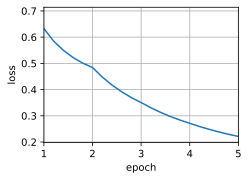

In [76]:
lr, num_epochs = 0.01, 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
train(net, data_iter, lr, num_epochs, device)

# 3) Applying the embedding
After training the word embedding model, we can represent similarity in meaning between words based on the cosine similarity of two word vectors.

Warning: you must input  word existing in vocabulary dict.

In [107]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab.doc2idx([query_token])[0]]
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W*W, dim=1) * torch.sum(x*x) + 1e-9)
    topk = torch.topk(cos, k=k +1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:
        print(f'cosine sim={float(cos[i]):.3f}: {vocab[i]}')
get_similar_tokens('god', 3, net[0])

cosine sim=0.503: communicated
cosine sim=0.497: gained
cosine sim=0.470: invent
